In [2]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

In [3]:
#define variables

wells_df = pd.read_csv('C:/Users/rcorrigan/Documents/PASCO/HWW_XY_StatePlane.csv')
geometry = [Point(xy) for xy in zip(wells_df['X'], wells_df['Y'])]
wells_gdf = gpd.GeoDataFrame(wells_df, geometry=geometry)

grid_gdf = gpd.read_file('C:/Users/rcorrigan/Documents/PASCO/grid_stateplane.shp')

wells_gdf = wells_gdf.set_crs(grid_gdf.crs) #set wells crs to grid crs 

wells_in_grid = gpd.sjoin(wells_gdf, grid_gdf, how='inner', predicate='within')

wells_in_grid['centroid'] = wells_in_grid['geometry'].centroid

wells_in_grid['centroid_X'] = wells_in_grid['centroid'].x
wells_in_grid['centroid_Y'] = wells_in_grid['centroid'].y

num_points = 25
radius = 0.25 #0.25 from centroid (0.5, 0.5)

In [4]:
def generate_circle(x, y, num_points, radius):
    angles = np.linspace(0, 2 * np.pi, num_points, endpoint=False)
    
    x_points = x + radius * np.cos(angles)
    y_points = y + radius * np.sin(angles)
    
    return [Point(xy) for xy in zip(x_points, y_points)]


In [7]:
def generate_points_around_centroids(wells_in_grid, num_points, radius):
    all_points = []
    
    for index, row in wells_in_grid.iterrows():
        centroid_x = row['centroid_X']
        centroid_y = row['centroid_Y']
        grid_row = row['SubRow']
        grid_col = row['SubCol']
        
        points = generate_circle(centroid_x, centroid_y, num_points, radius)
        
        
        for point in points:
            local_x = point.x - centroid_x + 0.5  # Local X relative to centroid
            local_y = point.y - centroid_y + 0.5  # Local Y relative to centroid
            
            all_points.append({
                'grid_index': index,  
                'geometry': point,
                'Row':grid_row,
                'Col':grid_col,
                'local_X': local_x,
                'local_Y': local_y
            })
        
            
    points_gdf = gpd.GeoDataFrame(all_points)
    
    return points_gdf

In [9]:
points_gdf = generate_points_around_centroids(wells_in_grid, num_points, radius)
points_gdf['local_GeomX'] = points_gdf.geometry.x
points_gdf['local_GeomY'] = points_gdf.geometry.y

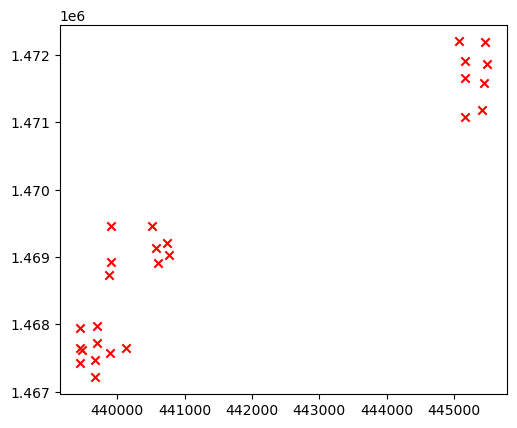

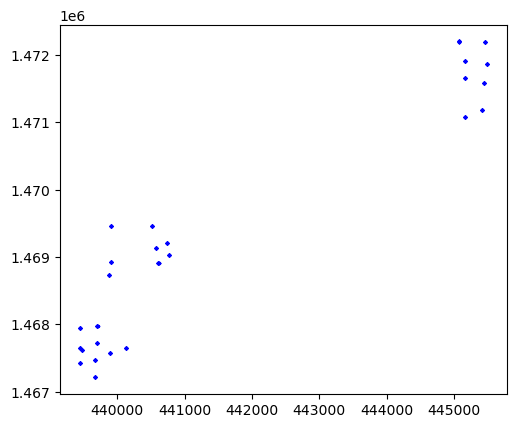

In [10]:
wells_in_grid.plot(ax=plt.gca(), marker='x', color='red')
points_gdf.plot(marker='o', color='blue', markersize=2)
plt.show()

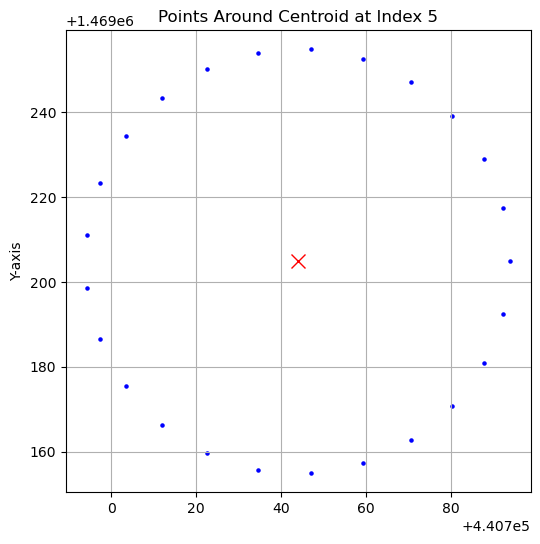

In [11]:

#check that point look correct around one centroid
index = 5 
selected_row = wells_in_grid.iloc[index]


centroid_x = selected_row['centroid_X']
centroid_y = selected_row['centroid_Y']


num_points = 25
radius = 50
points = generate_circle(centroid_x, centroid_y, num_points, radius)


points_gdf = gpd.GeoDataFrame(geometry=points)

plt.figure(figsize=(6, 6))
points_gdf.plot(marker='o', color='blue', markersize=5, ax=plt.gca(), label='Generated Points')
plt.plot(centroid_x, centroid_y, 'rx', markersize=10, label='Centroid')  
plt.ylabel('Y-axis')
plt.title(f'Points Around Centroid at Index {index}')
plt.axis('equal')
plt.grid(True)
plt.show()

In [ ]:
# L, R, C, Local X, Local Y, Local Z, time offset (0.0), drape option (0)
local_z = 0.5 
t_offset = 0.0
drape = 0
layer = 1

points_gdf['local_z'] = local_z
points_gdf['t_offset'] = t_offset
points_gdf['drape'] = 0
points_gdf['layer']= layer

starting_loc = points_gdf[['layer', 'Row', 'Col', 'local_X', 'local_Y', 'local_z', 't_offset', 'drape']]
starting_loc.to_csv("StartingLocations.csv")